In [1]:
import wrds
import pandas as pd
import numpy as np
from scipy import stats
import scipy.linalg as la
from scipy.integrate import quad
from sklearn.metrics import make_scorer
from sklearn import linear_model
from sklearn import model_selection
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import linearmodels as lm
exec(open("/home/amz5/functionsByAnthony.py").read()) # do whatever is in functionsByAnthony.py
from statsmodels.iolib.summary2 import summary_col

In [2]:
df=pd.read_pickle('perfall.pkl')
comp=pd.read_pickle('comp.pkl')

In [3]:
def rsquared(mod,dat):
    np.nanmean(dat["real"])
    sse=((dat[[mod,'real']].dropna()[mod]-dat[[mod,'real']].dropna()["real"])**2).sum()
    tss=(dat[[mod,'real']].dropna()["real"]**2).sum()
    return 1-sse/tss

In [4]:
df["mverank"]=df.groupby(by=["month","year"])["mvel1"].rank()

In [5]:
df=df.merge(pd.DataFrame(df.groupby(by=["month","year"])["mverank"].max()).reset_index().rename(columns={'mverank':'mverank_max'}), 
         how='left', left_on=["month", "year"], right_on=["month", "year"])

In [6]:
dfBottom=df[df["mverank"]<=1000]
dfTop=df[(df["mverank"]>=df["mverank_max"]-1000)]

In [7]:
table1=pd.DataFrame(100*np.array([[rsquared('OLS-3+H', df), rsquared('PLS', df), rsquared('E-Net', df), rsquared('RF', df)],
                     [rsquared('OLS-3+H', dfTop), rsquared('PLS', dfTop), rsquared('E-Net', dfTop), rsquared('RF', dfTop)],
                     [rsquared('OLS-3+H', dfBottom), rsquared('PLS', dfBottom), rsquared('E-Net', dfBottom), rsquared('RF', dfBottom)]]),
             columns=['OLS3H','PLS','ENet','RF'], index=['All', 'Top 1,000', 'Bottom 1,000'])

<ipython-input-8-316b5c92e598>:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig3.tight_layout()


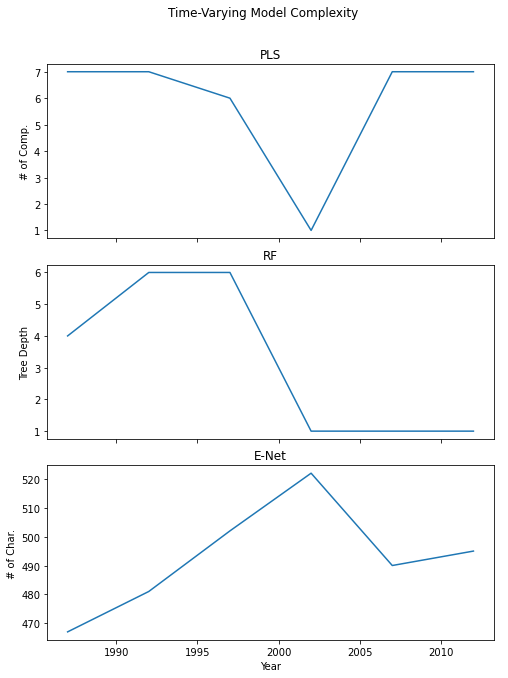

In [8]:
fig3, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex=True, sharey=False, constrained_layout=True)
fig3.suptitle('Time-Varying Model Complexity')
ax1.plot(comp.index, comp.PLSComp)
ax1.set_title('PLS')
ax1.set_ylabel('# of Comp.')

ax2.plot(comp.index, comp.RFDepth)
ax2.set_title('RF')
ax2.set_ylabel('Tree Depth')


ax3.plot(comp.index, comp.ENetChar)
ax3.set_title('E-Net')
ax3.set_ylabel('# of Char.')

plt.grid(False)
fig3.add_subplot(1, 1, 1, frame_on=False)


plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Year")

fig3.tight_layout()
fig3.set_size_inches(8,10)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.01, hspace=0.15)

In [9]:
def ports(dat, var):
    dat[var+"_rank"]=dat.groupby(["month", "year"])[var].rank()
    dat1=dat.merge(pd.DataFrame(dat.groupby(by=["month","year"])[var+"_rank"].max()).reset_index().rename(columns={var+'_rank':var+'_len'}), 
         how='left', left_on=["month", "year"], right_on=["month", "year"])
    dat1[var+"_q"]=dat1[var+"_rank"]/dat1[var+"_len"]
    del dat1[var+"_rank"]
    del dat1[var+"_len"]
    dat1[var+"_rank"]=np.where(dat1[var+"_q"]<.1,1,
                              np.where(dat1[var+"_q"]<.2,2, np.where(dat1[var+"_q"]<.3,3,
                              np.where(dat1[var+"_q"]<.4,4, np.where(dat1[var+"_q"]<.5,5,
                              np.where(dat1[var+"_q"]<.6,6, np.where(dat1[var+"_q"]<.7,7,
                              np.where(dat1[var+"_q"]<.8,8, np.where(dat1[var+"_q"]<.9,9,10))))))))
                              )
    del dat1[var+"_q"]
    return dat1

for mod in ['OLS-3+H', 'PLS','E-Net', 'RF']:
    df=ports(df, mod)

In [10]:
def sumr(data):
    df1 = pd.DataFrame(np.nan,index=data.index,columns=['sum'])
    df1['sum'] = data.sum()
    return df1

df["mvel1_sum"]=df.groupby(by=["month", "year", "RF_rank"]).mvel1.apply(sumr)

## mkt weight
df["mktwght"]=df["mvel1"]/df["mvel1_sum"]
df["wret"]=df["real"]*df["mktwght"]

In [11]:
rfportew=pd.DataFrame(df.groupby(by=["month","year", "RF_rank"]).real.mean()).reset_index()
rfportvw=pd.DataFrame(df.groupby(by=["month","year", "RF_rank"]).wret.sum()).reset_index()
rfportall=rfportvw.merge(rfportew, how='left', left_on=['month', 'year', 'RF_rank'],
                        right_on=['month', 'year', 'RF_rank']).rename(columns={'real':'ew', 'wret':'vw'})

ff=pd.read_csv('F-F_Research_Data_Factors.CSV')
ff[['Mkt-RF', 'RF']]=ff[['Mkt-RF', 'RF']]/100
ff["Month"]=pd.to_datetime(ff['Month'], format='%Y%m', errors='coerce')
ff["month"]=pd.DatetimeIndex(ff.Month).month
ff["year"]=pd.DatetimeIndex(ff.Month).year

rfportall=rfportall.merge(ff[['month', 'year', 'Mkt-RF', 'RF']], how='left', left_on=['month', 'year'], right_on=['month', 'year'])
rfportall['Mkt']=rfportall['Mkt-RF']+rfportall['RF']
rfportall[['vw', 'ew', 'Mkt']]=1+rfportall[['vw', 'ew', 'Mkt']]

In [12]:
tst=rfportall.groupby(by=["year", "RF_rank"])['vw','ew', 'Mkt'].prod().reset_index()

<ipython-input-12-4e9eaa1d3bc0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tst=rfportall.groupby(by=["year", "RF_rank"])['vw','ew', 'Mkt'].prod().reset_index()


In [13]:
#rfportall.year.unique()
alldat=pd.DataFrame()
for yr in rfportall.year.unique():
    tst1=tst[tst["year"]<=yr].groupby(by="RF_rank")['vw','ew', 'Mkt'].prod().reset_index()
    tst1["year"]=yr
    alldat=alldat.append(tst1)

<ipython-input-13-9e216127a877>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tst1=tst[tst["year"]<=yr].groupby(by="RF_rank")['vw','ew', 'Mkt'].prod().reset_index()


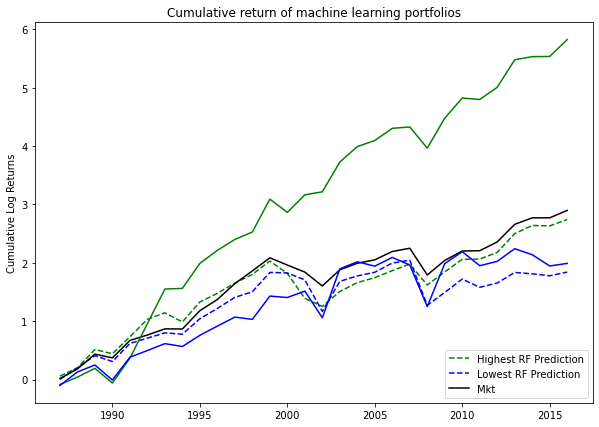

In [14]:
fig9= plt.figure()
plt.plot(alldat[alldat["RF_rank"]==10]["year"], np.log(alldat[alldat["RF_rank"]==10]["vw"]), 'g--')
plt.plot(alldat[alldat["RF_rank"]==1]["year"], np.log(alldat[alldat["RF_rank"]==1]["vw"]), 'b--')
plt.plot(alldat[alldat["RF_rank"]==1]["year"], np.log(alldat[alldat["RF_rank"]==1]["Mkt"]), color='k')

plt.plot(alldat[alldat["RF_rank"]==10]["year"], np.log(alldat[alldat["RF_rank"]==10]["ew"]), 'g')
plt.plot(alldat[alldat["RF_rank"]==1]["year"], np.log(alldat[alldat["RF_rank"]==1]["ew"]), 'b')

plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative return of machine learning portfolios')
plt.legend(["Highest RF Prediction", "Lowest RF Prediction", "Mkt"], loc ="lower right")
fig9.set_size_inches(10,7)

In [18]:
vwsharp=pd.DataFrame((rfportall.groupby('RF_rank').vw.mean()-1)/(rfportall.groupby('RF_rank').vw.std())).rename(columns={'vw':'SR (VW)'}).reset_index().rename(columns={'RF_rank':'RF Rank'})
ewsharp=pd.DataFrame((rfportall.groupby('RF_rank').ew.mean()-1)/(rfportall.groupby('RF_rank').ew.std())).rename(columns={'ew':'SR (EW)'}).reset_index().rename(columns={'RF_rank':'RF Rank'})
sharps=vwsharp.merge(ewsharp).set_index('RF Rank')

In [39]:
mkt=sharps[:1]
mkt.index=["Mkt"]
mkt['SR (VW)']=pd.DataFrame((rfportall.groupby('RF_rank').Mkt.mean()-1)/(rfportall.groupby('RF_rank').Mkt.std()))[:1]["Mkt"].unique()
mkt['SR (EW)']=np.nan

In [42]:
sharps=sharps.append(mkt)

In [46]:
df["mvel1_sumAll"]=df.groupby(by=["month", "year"]).mvel1.apply(sumr)

## mkt weight
df["mktwghtAll"]=df["mvel1"]/df["mvel1_sumAll"]
df["wretAll"]=df["real"]*df["mktwghtAll"]
df["PredAll"]=df["RF"]*df["mktwghtAll"]

In [64]:
tst2=df.groupby(by=["year", "month"])["PredAll","wretAll"].sum().reset_index()
tst3=df.groupby(by=["year", "month"])["RF", 'real'].mean().reset_index()
tst2=tst2.merge(tst3, how='left', left_on=["month", "year"], right_on=["month", "year"])

<ipython-input-64-feeedc0d5d7b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tst2=df.groupby(by=["year", "month"])["PredAll","wretAll"].sum().reset_index()
<ipython-input-64-feeedc0d5d7b>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tst3=df.groupby(by=["year", "month"])["RF", 'real'].mean().reset_index()


In [96]:
mktrsq=pd.DataFrame(np.round(100*np.array([[1-np.sum((tst2["wretAll"]-tst2["PredAll"])**2)/np.sum((tst2["wretAll"]-tst2["wretAll"].mean())**2),
                                   1-np.sum((tst2["real"]-tst2["RF"])**2)/np.sum((tst2["real"]-tst2["real"].mean())**2)],
                    [1-np.sum((tst2["wretAll"]-tst2["PredAll"])**2)/np.sum((tst2["wretAll"]-0.1/12)**2),
                     1-np.sum((tst2["real"]-tst2["RF"])**2)/np.sum((tst2["real"]-0.1/12)**2)],                                           
                    [1-np.sum((tst2["wretAll"]-tst2["PredAll"])**2)/np.sum((tst2["wretAll"]-0.05/12)**2),
                     1-np.sum((tst2["real"]-tst2["RF"])**2)/np.sum((tst2["real"]-0.05/12)**2)],
                    [1-np.sum((tst2["wretAll"]-tst2["PredAll"])**2)/np.sum((tst2["wretAll"]-0)**2),
                     1-np.sum((tst2["real"]-tst2["RF"])**2)/np.sum((tst2["real"]-0)**2)]
                                          ]), 2),
                   columns=["Value-Weighted","Equal-Weighted"],index=["Benchmark=Forward Mean","Benchmark= 10\% annually","Benchmark= 5\% annually","Benchmark=0" ])
mktrsq

,Value-Weighted,Equal-Weighted
Benchmark=Forward Mean,2.14,3.63
Benchmark= 10\% annually,2.18,3.79
Benchmark= 5\% annually,3.31,4.96
Benchmark=0,5.94,7.19


In [ ]:
table1=pd.DataFrame(100*np.array([[rsquared('OLS-3+H', df), rsquared('PLS', df), rsquared('E-Net', df), rsquared('RF', df)],
                     [rsquared('OLS-3+H', dfTop), rsquared('PLS', dfTop), rsquared('E-Net', dfTop), rsquared('RF', dfTop)],
                     [rsquared('OLS-3+H', dfBottom), rsquared('PLS', dfBottom), rsquared('E-Net', dfBottom), rsquared('RF', dfBottom)]]),
             columns=['OLS3H','PLS','ENet','RF'], index=['All', 'Top 1,000', 'Bottom 1,000'])

In [ ]:
###############################
## The rest of the notebook simply creates a .tex file which can be compiled to generate 
## GKSSummary.pdf, containing the main results produced above
#######

In [97]:
#Open the latex output file
nm="GKXSummary.tex"
tabcount=1
figcount=1
latexopen(nm, 1)
def ctab():
    global tabcount
    tabcount=tabcount+1
    return
def cfig():
    global figcount
    figcount=figcount+1
    return

latexwrite(nm, "Table "+str(tabcount), "")

latextable(table1, nm, title= "Out-of-sample R-squared (\%) by model type ",escape=False)
ctab()
latexwrite(nm, "Table "+str(tabcount), "")

latextable(sharps, nm, title= "Sharpe Ratios of RF Portfolios",escape=False, mid_rule_above='Mkt')
ctab()
latexwrite(nm, "Table "+str(tabcount), "")

latextable(mktrsq, nm, title= "Out-of-sample R-squared (\%) Predicting CRSP Portfolios",escape=False, mid_rule_above='Mkt')
ctab()

###############################
### Figures
###############################

latexwrite(nm, "Figure "+str(figcount), "")
latexplot(fig3, nm, "fig3", '0cm', scale=.7)
cfig()

latexwrite(nm, "Figure "+str(figcount), "")
latexplot(fig9, nm, "fig9", '0cm', scale=.7)
cfig()
#compile command: pdflatex -pdf GKXSummary.tex